# RNN for R-peak detection using the pytorch library

In [28]:
import os
import random
import numpy as np
import neurokit2 as nk
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from customLib.vis import *
from customLib.preprocess import *
from customLib.peak_detection import *
from customLib.load_ptbxl import load_ptbxl

In [53]:
DATASET_PATH = "./dataset"

LSTM_HIDDEN_SIZE = 64
EPOCHS = 20
BATCH_SIZE = 50
LR = 1e-2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training will be performed with:',device)

Training will be performed with: cuda:0


In [30]:
x_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_train.npy")), 2)[:8000]
y_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_train.npy")), 2)[:8000] # if conv is used the expand at dim 1

x_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_test.npy")), 2)[:1500]
y_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_test.npy")), 2)[:1500]

x_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_val.npy")), 2)[:500]
y_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_val.npy")), 2)[:500]

In [31]:
class ECGDataset(Dataset):
  def __init__(self, data, labels):
    super(ECGDataset, self).__init__()
    self.data = data
    self.labels = labels

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    sample = torch.tensor(self.data[idx], dtype=torch.float32)
    label = torch.tensor(self.labels[idx], dtype=torch.float32)
    return sample, label

In [32]:
class WeightedBCELoss(torch.nn.Module):
  def __init__(self, negative_weight=None, positive_weight=None):
    super(WeightedBCELoss, self).__init__()
    self.w_n = negative_weight
    self.w_p = positive_weight

  def forward(self, prediction, ground_truth, epsilon=1e-7):
    if self.w_n is None or self.w_p is None:
        # Calculate weights for the current batch
        pos_weight = (ground_truth == 1).float().sum()
        neg_weight = (ground_truth == 0).float().sum()
        total = pos_weight + neg_weight
        self.w_p = neg_weight / total
        self.w_n = pos_weight / total
    
    loss_pos = -1 * self.w_p * (ground_truth * torch.log(prediction + epsilon)).mean()
    loss_neg = -1 * self.w_n * ((1 - ground_truth) * torch.log(1 - prediction + epsilon)).mean()
  
    return loss_pos + loss_neg


In [33]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
      super(LSTM, self).__init__()
      self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, dropout=0.3)
      self.relu = torch.nn.ReLU()
      # achieveing better results with Dense layer instead of Conv1d and when dropout is used after lstm instead of Dense layer
      #self.conv = torch.nn.Conv1d(kernel_size=1, in_channels=hidden_size, out_channels=1) 
      self.flatten = torch.nn.Flatten()
      self.dense = torch.nn.Linear(in_features=hidden_size, out_features=1)
      self.sigmoid = torch.nn.Sigmoid()

      self.criterion = torch.nn.BCELoss() # WeightedBCELoss()
      self.optimizer = Adam(self.parameters(), lr=LR)

    def forward(self, x):
      x, _ = self.lstm(x)
      x = self.relu(x)
      x = self.dense(x)
      output = self.sigmoid(x)
      return output
    
    def train_model(self, x_train, y_train, epochs, batch_size=1, x_val=None, y_val=None,):
        self.batch_size = batch_size
        dataset = ECGDataset(x_train, y_train)
        train_loader = DataLoader(dataset, batch_size, shuffle=True)

        if x_val is not None:
            validation_dataset = ECGDataset(x_val, y_val)
            validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            running_loss = 0.0
            logs = ""

            self.train()
            for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
                x, y = x.to(device), y.to(device)

                self.optimizer.zero_grad()
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_loss += loss.item()

                loss.backward()
                self.optimizer.step()

            logs += f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss / len(train_loader)}]"
            if x_val is not None:
                vloss = self.validate(validation_loader)
                logs += f" Validation Loss: {vloss}"

            print(logs)

    def validate(self, validation_loader):
        running_vloss = 0.0
        self.eval()

        with torch.no_grad():
            for i, (x_val, y_val) in enumerate(validation_loader):
                x, y = x_val.to(device), y_val.to(device)
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_vloss += loss.item()

        return running_vloss / len(validation_loader)

    def test_model(self, x_test, y_test):

        test_dataset = ECGDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

        running_loss = 0.0
        self.eval()
        with torch.no_grad():
            for i, (x_test, y_test) in enumerate(test_loader):
                x, y = x_test.to(device), y_test.to(device)
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_loss += loss.item()

                if i % int(len(test_loader)/5) == 0:
                    y_test = torch.Tensor.numpy(y_test[0].cpu()).flatten()
                    x_test = torch.Tensor.numpy(x_test[0].cpu()).flatten()
                    outputs = torch.Tensor.numpy(outputs[0].cpu()).flatten()

                    plt.figure(figsize=(10,10))
                    plt.subplot(3,1,1)
                    plt.plot(x_test)
                    plt.grid()
                    plt.title("ECG")
                    plt.subplot(3,1,2)
                    plt.plot(y_test)
                    plt.grid()
                    plt.title("Y true")
                    plt.subplot(3,1,3)
                    plt.plot(outputs)
                    plt.grid()
                    plt.title("Y pred")
                    plt.show()

        print("Test loss: {:.2f}".format(running_loss / len(test_loader)))


In [34]:
dataset = ECGDataset(x_train, y_train)
train_loader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

In [35]:
model = LSTM(input_size=1, hidden_size=LSTM_HIDDEN_SIZE) #input_size == hidden features size (1-lead ECG)
model.to(device)

e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (lstm): LSTM(1, 64, batch_first=True, dropout=0.3)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
)

In [36]:
model.train_model(x_train=x_train, y_train=y_train, epochs=EPOCHS, x_val=x_val, y_val=y_val, batch_size=BATCH_SIZE)

100%|██████████| 160/160 [00:01<00:00, 83.05it/s]


Epoch [1/20] Loss: 0.07561643039807678] Validation Loss: 0.058054262027144435


100%|██████████| 160/160 [00:01<00:00, 90.49it/s]


Epoch [2/20] Loss: 0.04956382361706346] Validation Loss: 0.029872560873627663


100%|██████████| 160/160 [00:02<00:00, 72.06it/s]


Epoch [3/20] Loss: 0.0331863631028682] Validation Loss: 0.021718626096844672


100%|██████████| 160/160 [00:02<00:00, 64.07it/s]


Epoch [4/20] Loss: 0.015093737858114764] Validation Loss: 0.016579067520797252


100%|██████████| 160/160 [00:02<00:00, 64.86it/s]


Epoch [5/20] Loss: 0.009226913514430635] Validation Loss: 0.01954356487840414


100%|██████████| 160/160 [00:02<00:00, 64.41it/s]


Epoch [6/20] Loss: 0.007621686632046476] Validation Loss: 0.021311884745955467


100%|██████████| 160/160 [00:02<00:00, 65.10it/s]


Epoch [7/20] Loss: 0.006631146164727398] Validation Loss: 0.023062213137745858


100%|██████████| 160/160 [00:02<00:00, 64.79it/s]


Epoch [8/20] Loss: 0.00605078564840369] Validation Loss: 0.023304610513150692


100%|██████████| 160/160 [00:02<00:00, 64.10it/s]


Epoch [9/20] Loss: 0.00560749361757189] Validation Loss: 0.02157737035304308


100%|██████████| 160/160 [00:02<00:00, 64.78it/s]


Epoch [10/20] Loss: 0.005219528876477852] Validation Loss: 0.020601101219654083


100%|██████████| 160/160 [00:02<00:00, 65.12it/s]


Epoch [11/20] Loss: 0.004933471526601352] Validation Loss: 0.021620925329625607


100%|██████████| 160/160 [00:02<00:00, 65.17it/s]


Epoch [12/20] Loss: 0.004671665416390169] Validation Loss: 0.023565433267503978


100%|██████████| 160/160 [00:02<00:00, 64.72it/s]


Epoch [13/20] Loss: 0.004658721158921253] Validation Loss: 0.017627119552344084


100%|██████████| 160/160 [00:02<00:00, 64.96it/s]


Epoch [14/20] Loss: 0.00435042370663723] Validation Loss: 0.017698619235306978


100%|██████████| 160/160 [00:02<00:00, 65.16it/s]


Epoch [15/20] Loss: 0.004192820230673533] Validation Loss: 0.017722813971340658


100%|██████████| 160/160 [00:02<00:00, 64.71it/s]


Epoch [16/20] Loss: 0.00410271342843771] Validation Loss: 0.017723196279257537


100%|██████████| 160/160 [00:02<00:00, 64.79it/s]


Epoch [17/20] Loss: 0.004032554411969614] Validation Loss: 0.019173671677708625


100%|██████████| 160/160 [00:02<00:00, 64.96it/s]


Epoch [18/20] Loss: 0.004003620988805778] Validation Loss: 0.017545776814222334


100%|██████████| 160/160 [00:02<00:00, 64.36it/s]


Epoch [19/20] Loss: 0.0038830699340905994] Validation Loss: 0.018099239002913235


100%|██████████| 160/160 [00:02<00:00, 64.71it/s]

Epoch [20/20] Loss: 0.003841019333049189] Validation Loss: 0.017742804996669293


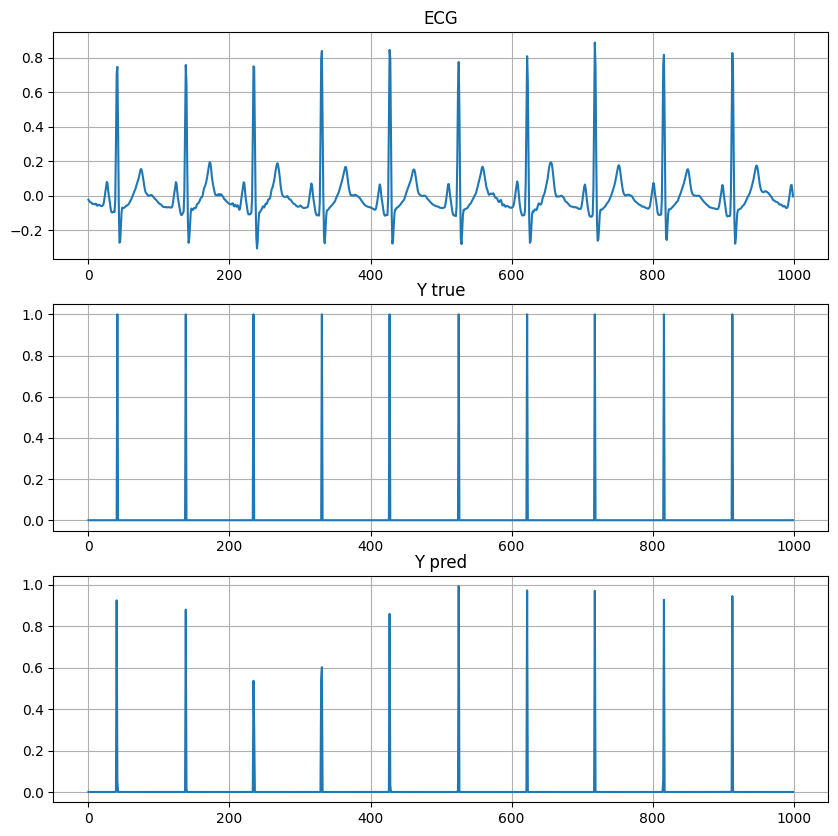

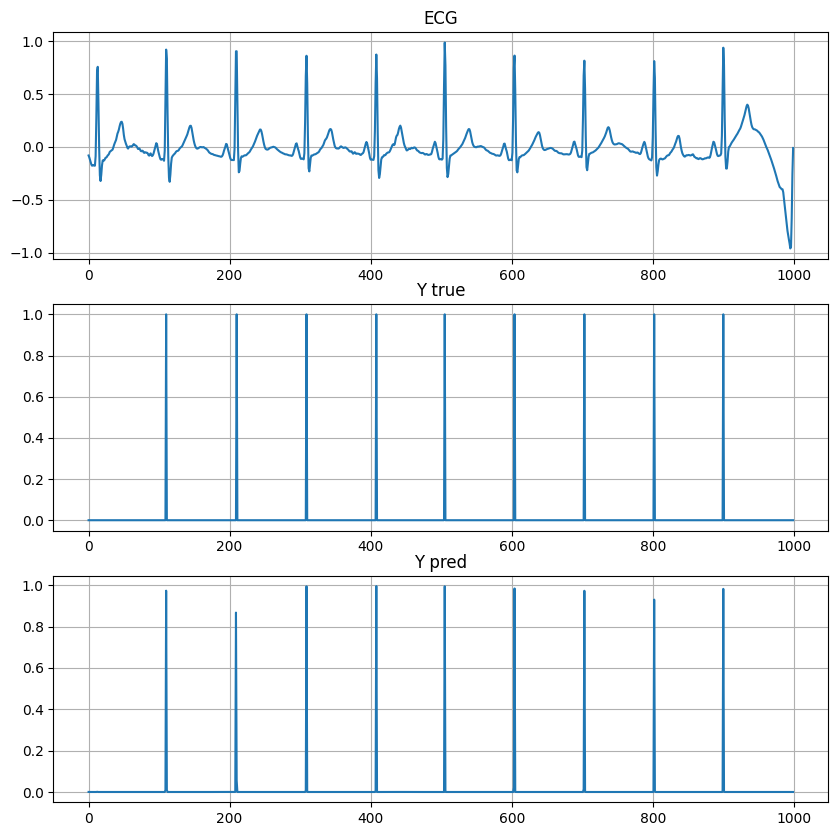

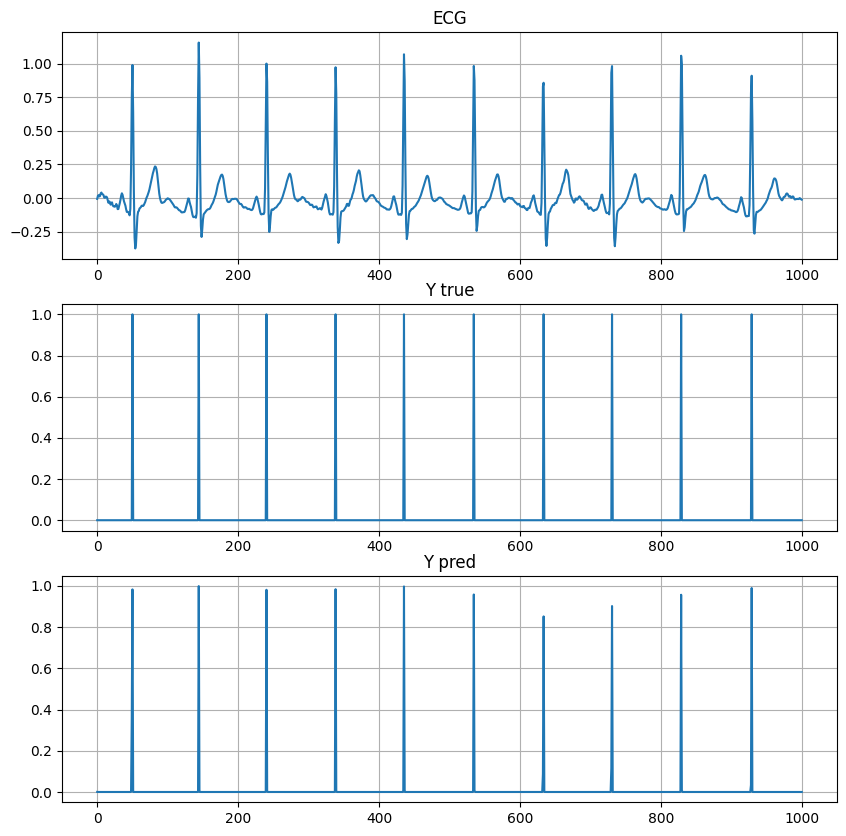

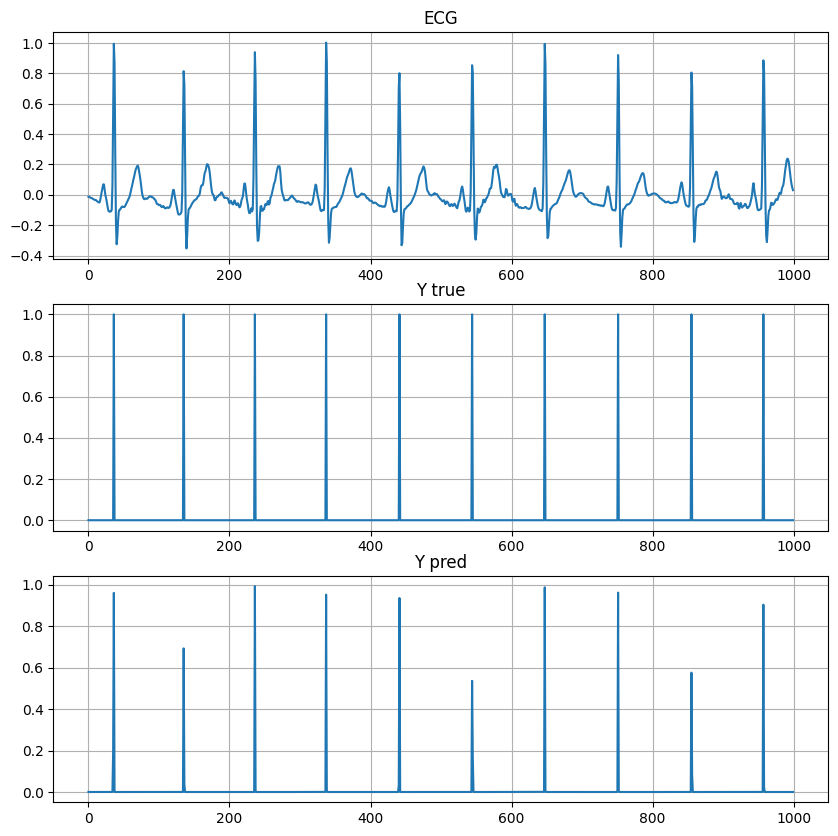

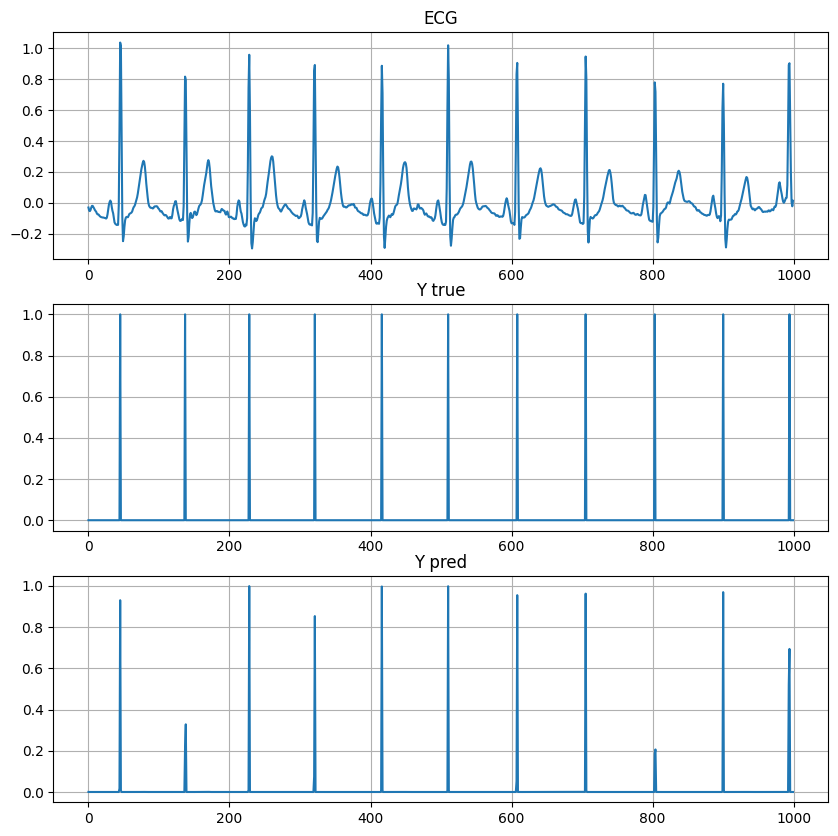

Test loss: 0.00


In [37]:
model.test_model(x_test=x_test, y_test=y_test)

### Testing with own ECG recording

In [ ]:
my_test = np.load("E:\\ml-data\\masters-thesis\\myDataset\\Patryk\\07-05-24_16_56.npy")

In [ ]:
ECGs = split_signal(signal=my_test, fs=250, overlap_factor=0.25, window_in_seconds=10)

In [ ]:
my_X = []
my_Y = []

for ECG in ECGs:
  ECG = norm_min_max(signal=ECG, lower=-1, upper=1)
  ECG = nk.ecg_clean(ecg_signal=ECG, sampling_rate=250)
  my_X.append(ECG)
  
  _, r_peaks = nk.ecg_peaks(ecg_cleaned=ECG, sampling_rate=250)
  r_peaks = r_peaks["ECG_R_Peaks"]
  y = np.zeros_like(ECG)
  y[r_peaks] = 1

  my_Y.append(y)

my_Y = np.array(my_Y)
my_X = np.array(my_X)
my_X = np.expand_dims(my_X, 2)
my_Y = np.expand_dims(my_Y, 2)

In [ ]:
model.test_model(x_test=my_X, y_test=my_Y)

### Downsampling own ECG from 250 Hz to 100 Hz

In [ ]:
from scipy.signal import resample

In [ ]:
ecg_data = my_X[0]
downsampled_ecg_data = resample(ecg_data, 1000)

In [ ]:
plt.figure(figsize=(5,15))
plt.subplot(4,1,1)
plt.plot(ecg_data, 'b-')
plt.title("Original")
plt.grid()
plt.subplot(4,1,2)
plt.plot(downsampled_ecg_data, 'g-')
plt.title("Downsamples")
plt.grid()
plt.show()

In [ ]:
my_X = []
my_Y = []

for ECG in ECGs:
  ECG = norm_min_max(signal=ECG, lower=-1, upper=1)
  ECG = nk.ecg_clean(ecg_signal=ECG, sampling_rate=250)
  ECG = resample(ECG, 1000)
  my_X.append(ECG)
  
  _, r_peaks = nk.ecg_peaks(ecg_cleaned=ECG, sampling_rate=100)
  r_peaks = r_peaks["ECG_R_Peaks"]
  y = np.zeros_like(ECG)
  y[r_peaks] = 1

  my_Y.append(y)

my_Y = np.array(my_Y)
my_X = np.array(my_X)
my_X = np.expand_dims(my_X, 2)
my_Y = np.expand_dims(my_Y, 2)

In [ ]:
model.test_model(x_test=my_X, y_test=my_Y)

### Result of downsampling from 250 Hz to 100 Hz
As the result of downsampling from 250 Hz to 100 Hz, the test loss function of the model is lower than the test loss function before the downsampling.

### Load additional dataset - PTB-XL

In [75]:
data = load_ptbxl(path="E:\\ml-data\\masters-thesis\\ptb-xl-v2\\WFDB", sampling_rate=100)
data = np.array(data)
data = np.expand_dims(data, 2)
data = torch.Tensor(data)
data = data.to(device)

100%|██████████| 5/5 [00:00<00:00, 333.38it/s]


In [76]:
results = model(data)

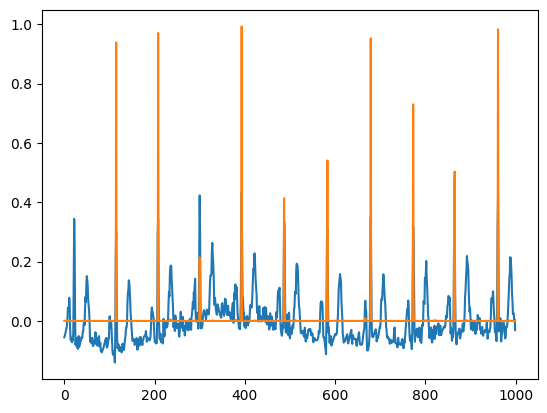

In [77]:
plt.plot(data[0].cpu())
plt.plot(results[0].cpu().detach().numpy())